In [34]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [35]:
import tensorflow as tf

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
from stock_data_processing import *
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

sns.set()
tf.random.set_seed(1234)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Dataset and Select Ticker

In [37]:
prefix = datetime.today().strftime('%Y-%m-%d')
ticker= "AAPL" #"AAPL" #"^SPX" #"TSLA"
# referene: https://www.youtube.com/watch?v=kGdbPnMCdOg
data = pd.read_csv(prefix+'-'+ticker+'.csv')
window=30
df = clean_stock_data(data, window)
df.head()

,date,open,high,low,close,adj_close,volume,stock_name,moving_max,moving_min,moving_avg_volume,moving_avg_HL
0,2020-02-27,70.275002,71.500000,68.239998,68.379997,66.377548,320605600,AAPL,68.379997,68.379997,320605600.0,3.260002
1,2020-02-28,64.315002,69.602501,64.092499,68.339996,66.338737,426510000,AAPL,68.379997,68.339996,373557800.0,4.385002
2,2020-03-02,70.570000,75.360001,69.430000,74.702499,72.514923,341397200,AAPL,74.702499,68.339996,362837600.0,4.900002
3,2020-03-03,75.917503,76.000000,71.449997,72.330002,70.211891,319475600,AAPL,74.702499,68.339996,351997100.0,4.812502
4,2020-03-04,74.110001,75.849998,73.282501,75.684998,73.468651,219178400,AAPL,75.684998,68.339996,325433360.0,4.363501


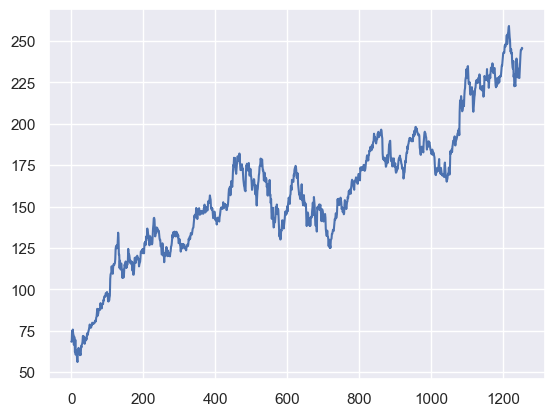

In [38]:
plt.plot(df['close'].values)

### Generate Useful Features

In [39]:
features = gen_features(df)
#only keep window-end samples before full window are invalid
features = features[window:]
features.head()

,close,volume,day_HL,sma,ema,rsi,macd_line,macd_signal,macd_histogram,bb_middle,bb_upper,bb_lower,target
30,0.556591,-0.386529,0.391808,0.280547,0.334503,7.007179,0.073660,0.045426,0.028233,0.280547,0.659364,-0.098271,0.024499
31,0.623708,-0.484065,0.594712,0.284453,0.362046,7.145366,0.087444,0.053830,0.033614,0.284453,0.676168,-0.107263,0.067118
32,0.799796,-0.217115,0.797957,0.324442,0.403737,6.909039,0.111294,0.065323,0.045971,0.324442,0.755237,-0.106353,0.176088
33,0.766365,-0.459814,0.460940,0.353963,0.438273,6.827276,0.126044,0.077467,0.048577,0.353963,0.821283,-0.113356,-0.033431
34,0.909117,-0.347287,0.478776,0.395735,0.483115,6.774795,0.147552,0.091484,0.056068,0.395735,0.905034,-0.113564,0.142753


### Generate LSTM train and test split

In [40]:
#target = -1 #predict closing delta
target = 0 #predict closing
data = features.to_numpy()
datax, datay = generate_LSTM_data(data, sequence_size=20, target_idx=target)
print('LSTM Data')
print("> Data X: " + str(datax.shape))
print("> Data y: " + str(datay.shape))
test_size = 30
datax_train = datax[:-test_size]
datay_train = datay[:-test_size]
print('Train Set')
print("> Data X: " + str(datax_train.shape))
print("> Data y: " + str(datay_train.shape))
datax_test = datax[-test_size:]
datay_test = datay[-test_size:]
print('Test Set')
print("> Data X: " + str(datax_test.shape))
print("> Data y: " + str(datay_test.shape))

LSTM Data
> Data X: (1203, 20, 13)
> Data y: (1203, 1)
Train Set
> Data X: (1173, 20, 13)
> Data y: (1173, 1)
Test Set
> Data X: (30, 20, 13)
> Data y: (30, 1)


### Define Model

In [41]:
class LSTM_Model(tf.keras.Model):
    def __init__(self, num_layers, hidden_dim, output_size, dropout_rate=0.1):
        super(LSTM_Model, self).__init__()
        
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.output_size = output_size

        self.lstm_layers = [
            tf.keras.layers.LSTM(
                hidden_dim,
                activation='tanh',
                return_sequences=True
            ) for _ in range(num_layers-1)
        ]
        self.last_lstm = tf.keras.layers.LSTM(
            hidden_dim,
            activation='tanh',
            return_sequences=False
        )
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dense1 = tf.keras.layers.Dense(hidden_dim//2)
        self.dense2 = tf.keras.layers.Dense(output_size)
    
    def call(self, x):
        for lstm_layer in self.lstm_layers:
            x = lstm_layer(x)
            x = self.dropout(x)
        x = self.last_lstm(x)
        x = self.dropout(x)
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        return x

### Train Model

In [42]:
mymodel = LSTM_Model(num_layers=5, hidden_dim=128, output_size=1, dropout_rate=0.1)
mymodel.compile(optimizer="adam", loss="mean_squared_error")
eval = mymodel.evaluate(datax_train, datay_train)

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.5611


In [43]:
history = mymodel.fit(
    x = datax_train,
    y = datay_train,
    validation_split=0.25,
    epochs=100,
    batch_size=128
)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 268ms/step - loss: 0.2961 - val_loss: 0.1490
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 248ms/step - loss: 0.1205 - val_loss: 0.1141
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step - loss: 0.1070 - val_loss: 0.1141
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step - loss: 0.1019 - val_loss: 0.1080
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 258ms/step - loss: 0.0877 - val_loss: 0.1105
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 241ms/step - loss: 0.0790 - val_loss: 0.1099
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 247ms/step - loss: 0.0725 - val_loss: 0.0962
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 241ms/step - loss: 0.0664 - val_loss: 0.0924
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 237ms/step - loss: 0.0637 - val_loss: 0.0943
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 251ms/step - loss: 0.0658 - val_loss: 0.0879
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - loss: 0.0604 - val_loss: 0.0890
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 248ms/step - loss: 0.

### Plot Performance

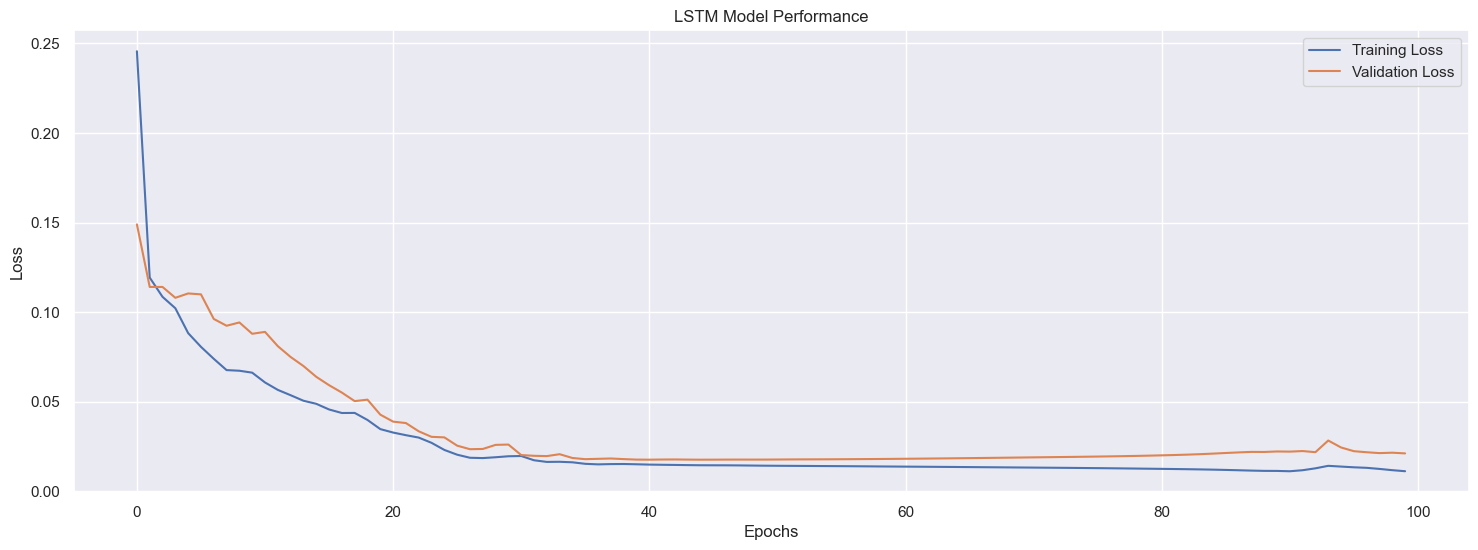

In [44]:
# Visualizing model performance during training
plt.figure(figsize=(18, 6))

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")

plt.title("LSTM Model Performance")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step


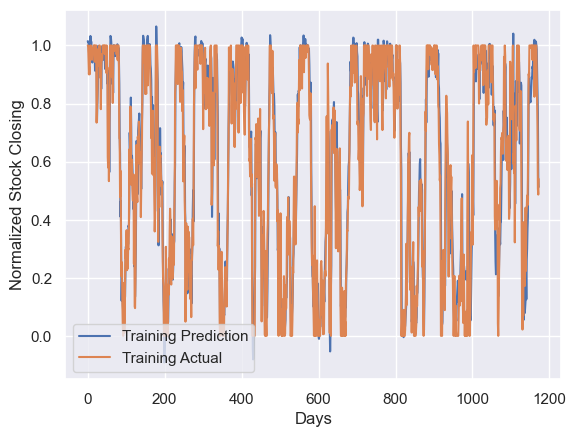

In [45]:
train_predictions = mymodel.predict(datax_train)
train_actual = datay_train
plt.plot(train_predictions, label='Training Prediction')
plt.plot(train_actual, label='Training Actual')
plt.xlabel('Days')
plt.ylabel('Normalized Stock Closing')
plt.legend()

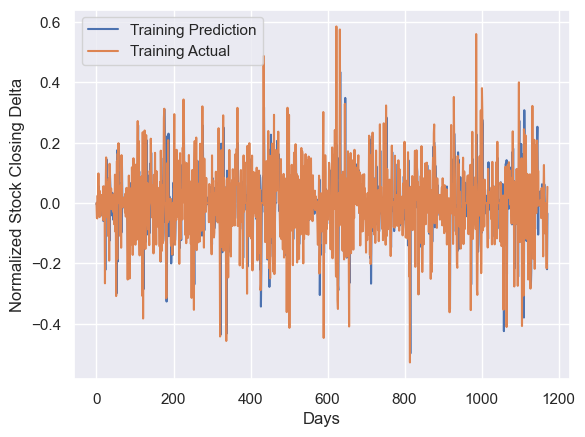

In [ ]:
training_diff = np.diff(train_predictions.flatten())
actual_diff = np.diff(train_actual.flatten())
plt.plot(training_diff, label='Training Prediction')
plt.plot(actual_diff, label='Training Actual')
plt.xlabel('Days')
plt.ylabel('Normalized Stock Closing Delta')
plt.legend()


In [ ]:
diff = np.sign(training_diff)-np.sign(actual_diff)
thresh = np.max(np.abs(training_diff))/4
significant = np.where(np.abs(training_diff) > thresh)
print('We perform predictions for ' + str(len(diff)) + ' days')
print('Let a significant day be a day where the absolute value of the predicted closing delta is greater than ' + str(thresh))
print('There are ' + str(len(significant[0])) + ' such events')
print('Of those events, we predict ' + str(np.count_nonzero(diff[significant])) + ' incorrectly' )



We perform predictions for 1172 days
Let a significant day be a day where the absolute value of the predicted closing delta is greater than 0.12457225
There are 194 such events
Of those events, we predict 87 incorrectly


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


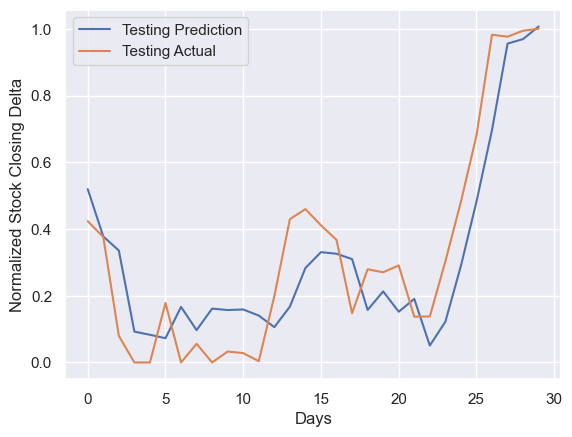

In [48]:
test_predictions = mymodel.predict(datax_test)
test_actual = datay_test
plt.plot(test_predictions, label='Testing Prediction')
plt.plot(test_actual, label='Testing Actual')
plt.xlabel('Days')
plt.ylabel('Normalized Stock Closing Delta')
plt.legend()